# Discriminative vs Generative Models

### Load Data

In [2]:
# reading the data
read_data <- function(fname, sc) {
   data <- read.csv(file=fname,head=TRUE,sep=",")
   nr = dim(data)[1]
   nc = dim(data)[2]
   x = data[1:nr,1:(nc-1)]
   y = data[1:nr,nc]
   if (isTRUE(sc)) {
      x = scale(x)
      y = scale(y)
   }
   return (list("x" = x, "y" = y))
}

In [3]:
train <- read_data("data/train.csv", F)
test <- read_data("data/test.csv", F)

### Bayesian Classifier

Import the library to generate multivariate Gaussian samples and calculate the densities

In [4]:
library(mvtnorm) 

Warning message:
"package 'mvtnorm' was built under R version 3.6.3"

Create the function of Bayes Classifier of 2 different classes

In [5]:
BC <- function(train.x, train.y, test.x, test.y, classes){
    # Calculate class probabilities:
    p0.hat <- sum(train.y==classes[1])/length(train.y) # Probability of Class 1
    p1.hat <- sum(train.y==classes[2])/length(train.y) # Probability of Class 2
    
    # Calculate class means:
    mu0.hat <- colMeans(train.x[train.y==classes[1],]) # Calculate the mean of class 1
    mu1.hat <- colMeans(train.x[train.y==classes[2],]) # Calculate the mean of class 2
    
    # Calculate class covariance matrices:
    sigma0.hat <- var(train.x[train.y==classes[1],])
    sigma1.hat <- var(train.x[train.y==classes[2],])

    # Calculate shared covariance matrix:
    sigma.hat <- p0.hat * sigma0.hat + p1.hat * sigma1.hat 
    
    # Calculate posterior probabilities:
    posterior0 <- p0.hat*dmvnorm(x=train.x, mean=mu0.hat, sigma=sigma.hat)
    posterior1 <- p1.hat*dmvnorm(x=train.x, mean=mu1.hat, sigma=sigma.hat)
    
    # Calculate predictions:
    train.predict <- ifelse(posterior0 > posterior1, classes[1], classes[2])
    test.predict <- ifelse(p0.hat*dmvnorm(x=test.x, mean=mu0.hat, sigma=sigma.hat) > p1.hat*dmvnorm(x=test.x, mean=mu1.hat, sigma=sigma.hat), classes[1], classes[2])
    
    # calculate accuracy:
    train.acc <- sum(train.y==train.predict)/nrow(train.x)*100
    test.acc <- sum(test.y==test.predict)/nrow(test.x)*100

    return(list(train.acc, test.acc))
    
}

### Logistic Classifier
Before building the logistic classifier function, we create some auxiliary functions and initialize the SGD model

#### Auxilary Functions

In [6]:
# auxiliary function that predicts class labels
predict <- function(w, X, c0, c1){
    sig <- sigmoid(w, X)
    return(ifelse(sig>0.5, c1,c0))
}
    
# auxiliary function that calculate a cost function
cost <- function (w, X, T, c0){
    sig <- sigmoid(w, X)
    return(sum(ifelse(T==c0, 1-sig, sig)))
}

# Sigmoid function (=p(C1|X))
sigmoid <- function(w, x){
    return(1.0/(1.0+exp(-w%*%t(cbind(1,x)))))    
}

#### Initializations 
Now, we initiate the weight vector, learning rate, stopping threshold, etc.

In [7]:
# Initializations
tau.max <- 1000 # maximum number of iterations
eta <- 0.01 # learning rate
epsilon <- 0.01 # a threshold on the cost (to terminate the process)
tau <- 1 # iteration counter
terminate <- FALSE

**Step 2:** Here, we use SGD to learn the weight vector. Note that there are two loops. In the outter loop, we shuffle the samples and then start the inner loop. In the inner loop, we visit the training samples one by one and update the weights accordingly.

In [8]:
LR <- function(train.x, train.y, test.x, test.y, classes){ 
    ## Just a few name/type conversion to make the rest of the code easy to follow
    X <- as.matrix(train.x) # rename just for conviniance
    T <- train.y # rename just for conviniance

    W <- matrix(,nrow=tau.max, ncol=(ncol(X)+1)) # to be used to store the estimated coefficients
    W[1,] <- runif(ncol(W)) # initial weight (any better idea?)

    # project data using the sigmoid function (just for convenient)
    Y <- sigmoid(W[1,],X)

    costs <- data.frame('tau'=1:tau.max)  # to be used to trace the cost in each iteration
    costs[1, 'cost'] <- cost(W[1,],X,T, 1)

    while(!terminate){
        # check termination criteria:
        terminate <- tau >= tau.max | cost(W[tau,],X,T, 1)<=epsilon

        # shuffle data:
        train.len <- nrow(train.x)
        train.index <- sample(1:train.len, train.len, replace = FALSE)
        X <- X[train.index,]
        T <- T[train.index]

        # for each datapoint:
        for (i in 1:train.len){
            # check termination criteria:
            if (tau >= tau.max | cost(W[tau,],X,T, 1) <=epsilon) {terminate<-TRUE;break}

            Y <- sigmoid(W[tau,],X)

            # Update the weights
            W[(tau+1),] <- W[tau,] - eta * (Y[i]-T[i]) * cbind(1, t(X[i,]))

            # record the cost:
            costs[(tau+1), 'cost'] <- cost(W[tau,],X,T, 1)

            # update the counter:
            tau <- tau + 1

            # decrease learning rate:
            eta = eta * 0.999
        }
    }
    # Done!
    costs <- costs[1:tau, ] # remove the NaN tail of the vector (in case of early stopping)

    # the  final result is:
    w <- W[tau,]
    
    train.predict <- predict(w,train.x,-1,1)
    test.predict <- predict(w,test.x,-1,1)
    
    # calculate accuracy:
    train.acc <- sum(train.y==train.predict)/nrow(train.x)*100
    test.acc <- sum(test.y==test.predict)/nrow(test.x)*100

    return(list(train.acc, test.acc))
}

Using the first 5 data points from the training set, we trained a BC and a LR model, and compute their training and testing errors. In a “for loop”, increasing the size of training set (5 data points at a time), retraining the models and calculating their training and testing errors until all training data points are used. In one figure, we plotted the training errors of the BC and LR models (with different colors) versus the size of the training set and in the other 
figure, then we plotted the testing errors of the BC and LR models(with different colors) 8 versus the size of the training set.

In [9]:
accuracy <- data.frame('rows'=seq(5, nrow(train$x), 5), 'train.BC'=seq(5, nrow(train$x), 5), 'test.BC'=seq(5, nrow(train$x), 5), 'train.LR'=seq(5, nrow(train$x), 5), 'test.LR'=seq(5, nrow(train$x), 5))
cont <- 1
for (i in seq(5, nrow(train$x), 5)){
    accuracy[cont, 'train.BC'] <- BC(train$x[1:i,], train$y[1:i], test$x, test$y, c(1, -1))[1]
    accuracy[cont, 'test.BC'] <- BC(train$x[1:i,], train$y[1:i], test$x, test$y, c(1, -1))[2]
    accuracy[cont, 'train.LR'] <- LR(train$x[1:i,], train$y[1:i], test$x, test$y, c(1, -1))[1]
    accuracy[cont, 'test.LR'] <-  LR(train$x[1:i,], train$y[1:i], test$x, test$y, c(1, -1))[2]
    cont <- cont + 1
    }

Warning message:
"package 'ggplot2' was built under R version 3.6.3"

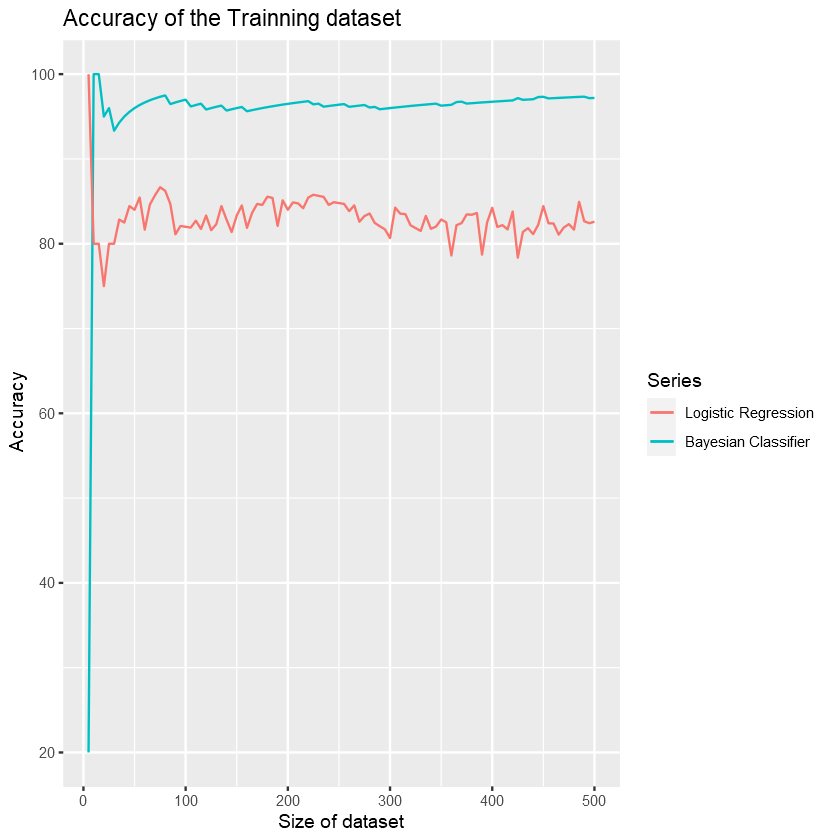

In [11]:
# load libraries:
library(ggplot2)
ggplot(data=accuracy) + geom_line(aes(x=rows, y=train.BC, color = "red")) + 
geom_line(aes(x=rows, y=train.LR, color = "blue")) +
scale_color_discrete(name = "Series", labels = c("Logistic Regression", "Bayesian Classifier")) + ylab("Accuracy") + 
xlab("Size of dataset") + ggtitle("Accuracy of the Trainning dataset")

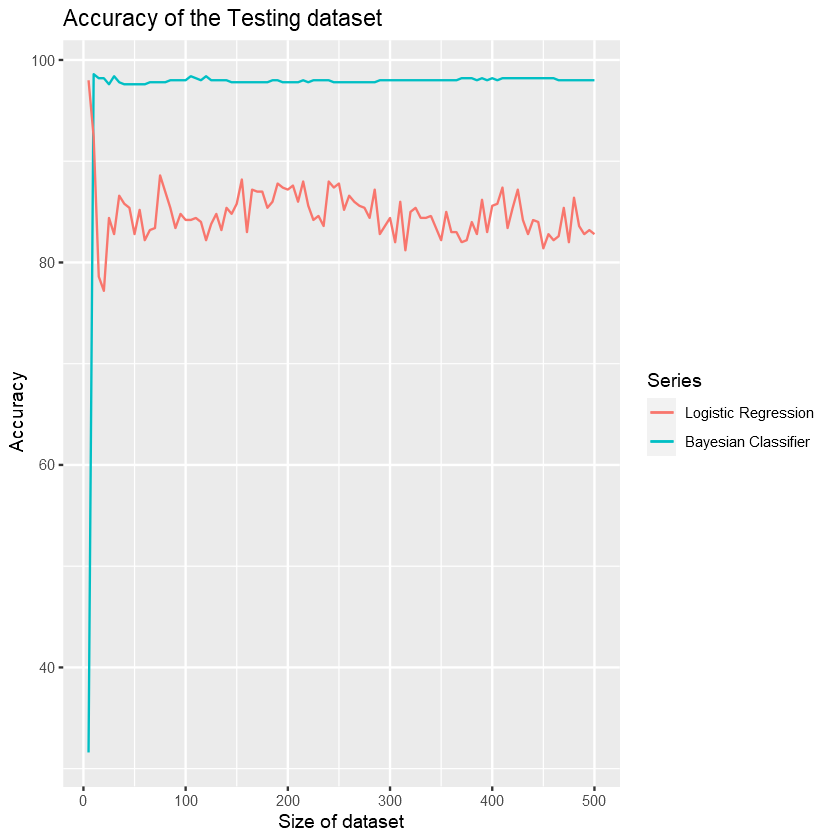

In [12]:
# load libraries:
library(ggplot2)
ggplot(data=accuracy) + geom_line(aes(x=rows, y=test.BC, color = "red")) + 
geom_line(aes(x=rows, y=test.LR, color = "blue")) +
scale_color_discrete(name = "Series", labels = c("Logistic Regression", "Bayesian Classifier")) + ylab("Accuracy") +
xlab("Size of dataset") + ggtitle("Accuracy of the Testing dataset")

With the first size of the dataset (5) it is pretty likely that the sample is unbalanced. There are only two classes so when we pick just 5 rows it is possible that the training dataset only have elements of one class or 4 elements of one class and only 1 of the other one. Therefore, the model is not able to predict the classes properly. 

After that, with more rows it can be seen that the accuracy even though is not pretty stable it goes around the same value, for both classifiers. After 10 rows of the training dataset the value does not change so much. Leading us to thing that the model just need a pretty good sample of the dataframe and this is more likely to append with at least ten rows, after that the results seem pretty similar with any size of the training dataset.

With a small dataset, a `Logistic Regression` has better accuracy than the `Bayes Clasiffier`, but after 10 rows the performance of the Logistic Regression decreases drastically and never recovers the accuracy it had with a small dataset. On the other hand, the Bayes classifier has bad performance with small datasets but as soon as the size of it increases the performance of this classifier is better than the logistic classifier performance. 

As we mentioned in task III.a, an especulation about the performance of each model with small datasets is that `Bayes Classifier` uses probability to classify the data, That is why if we use a small dataset the sample could not represent well the probability of each class in the entire dataset, therefore adding some noise to the prediction of the class. For the same reason the performance increases with more rows because of the law of large numbers, a bigger sample could represent better the entire dataset, and Bayes Classifier could perform better.